In [1]:
import time
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') # 展示高清图，在 Jupyter Notebook 中设置 matplotlib 图形的输出格式为 SVG 格式

import torch
import torch.nn as nn
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as TTS
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report

import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

E:\Anaconda\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 导入数据
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(r"F:\Code_Data\2_Rocks_Spectrum_Reflectance_essay_30_origin.csv",encoding='utf-8') #encoding='GBK',防止中文乱码

X = data.iloc[:,1:-1]
y = data.iloc[:,-1]
X_SG = savgol_filter(X, 5, 2)
X_SG_mms = MinMaxScaler().fit_transform(X_SG)
Label = LabelEncoder().fit_transform(y)
data.iloc[:,1:-1] = X_SG_mms
data.iloc[:, -1] = Label
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

X_dr = PCA(29).fit_transform(X)

# 转换为 torch 中的张量格式
X_tensor = torch.tensor(X_dr, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 将数据移动到GPU
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

Xtrain, Xtest, Ytrain, Ytest = TTS(X_dr,y,test_size=0.3,random_state=0)

# 转换为 torch 中的张量格式
X_train_tensor = torch.tensor(Xtrain, dtype=torch.float32)
X_test_tensor = torch.tensor(Xtest, dtype=torch.float32)
y_train_tensor = torch.tensor(Ytrain, dtype=torch.long)
y_test_array = Ytest.values
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long)

# 将数据移动到GPU
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# 创建训练集和测试集的 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建 DataLoader 对象
# train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_size = len(train_dataset)
test_size = len(test_dataset)

train_size, test_size

(8279, 3549)

In [3]:
# 搭建网络
class DNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layer_sizes, dropout_prob):
        ''' 搭建神经网络各层 '''
        super(DNN, self).__init__()

        self.hidden_layer_sizes = hidden_layer_sizes  # 调整隐藏层尺寸
        self.dropout_prob = dropout_prob  # 调整 dropout 概率

        layers = []
        prev_layer_size = input_size

        for layer_size in self.hidden_layer_sizes:
            layers.append(nn.Linear(prev_layer_size, layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout_prob))
            prev_layer_size = layer_size

        layers.append(nn.Linear(prev_layer_size, num_classes))

        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [4]:
# 遗传算法和贝叶斯优化超参数
num_classes = 33
input_size = X_tensor.shape[1]

# 'hidden_layer_size_0': 234, 'hidden_layer_size_1': 195, 'hidden_layer_size_2': 126, 'hidden_layer_size_3': 39, 'hidden_layer_size_4': 212
# 'learning_rate': 6.0208805506817975e-05, 'dropout_prob': 0.19, 'optimizer': 'RMSprop'}.
hidden_layer_sizes_1 = [234, 195, 126, 39, 212]
dropout_prob_1 = 0.19

# 'hidden_layer_size_0': 170, 'hidden_layer_size_1': 241, 'hidden_layer_size_2': 97, 'hidden_layer_size_3': 177, 'hidden_layer_size_4': 164
# 'learning_rate': 0.0028690154931344, 'dropout_prob': 0.16, 'optimizer': 'Adam'
hidden_layer_sizes_2 = [170, 241, 97, 177, 164]
dropout_prob_2 = 0.16

In [5]:
# 创建模型实例
model_1 = DNN(input_size, num_classes, hidden_layer_sizes_1, dropout_prob_1)
model_1.to(device)

model_2 = DNN(input_size, num_classes, hidden_layer_sizes_2, dropout_prob_2)
model_2.to(device)

print(model_1)
print()
print(model_2)

DNN(
  (net): Sequential(
    (0): Linear(in_features=29, out_features=234, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.19, inplace=False)
    (3): Linear(in_features=234, out_features=195, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.19, inplace=False)
    (6): Linear(in_features=195, out_features=126, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.19, inplace=False)
    (9): Linear(in_features=126, out_features=39, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.19, inplace=False)
    (12): Linear(in_features=39, out_features=212, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.19, inplace=False)
    (15): Linear(in_features=212, out_features=33, bias=True)
  )
)

DNN(
  (net): Sequential(
    (0): Linear(in_features=29, out_features=170, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.16, inplace=False)
    (3): Linear(in_features=170, out_features=241, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.16, inplace=False)
    (6): Linear(in_features=241, out_features=97, bi

In [6]:
# 训练网络——遗传算法——model_1
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量
learning_rate_1 = 6.0208805506817975e-05 # 设置学习率
optimizer_1 = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate_1)

epochs = 200
accuracies_1 = [] # 记录准确率变化的列表
losses_1 = [] # 记录损失函数变化的列表
model_1.train()
for epoch in range(epochs):
    total_correct_1 = 0
    total_samples_1 = 0
    batch_loss_1 = 0
    
    for (x, y) in train_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model_1(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)
        total_correct_1 += torch.sum(Pred_classes == y)
        total_samples_1 += y.size(0)
        loss = loss_fn(Pred, y) # 计算损失函数
        batch_loss_1 += loss.item()  # 累加当前 batch 的损失
        #losses.append(loss.item()) # 记录损失函数的变化
        optimizer_1.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer_1.step() # 优化内部参数
        
    accuracy_1 = total_correct_1 / total_samples_1
    accuracies_1.append(accuracy_1.item())
    losses_1.append(batch_loss_1 / len(train_dataloader))  # 计算平均损失并保存

In [7]:
max(accuracies_1)

0.9620726704597473

In [6]:
# 训练网络——贝叶斯优化——model_2
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量
# learning_rate_2 = 0.0014339229824059895 # 设置学习率
learning_rate_2 = 0.0028690154931344
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate_2)

epochs = 200
accuracies_2 = [] # 记录准确率变化的列表
losses_2 = [] # 记录损失函数变化的列表
model_2.train()
for epoch in range(epochs):
    total_correct_2 = 0
    total_samples_2 = 0
    batch_loss_2 = 0
    
    for (x, y) in train_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model_2(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)
        total_correct_2 += torch.sum(Pred_classes == y)
        total_samples_2 += y.size(0)
        loss = loss_fn(Pred, y) # 计算损失函数
        batch_loss_2 += loss.item()  # 累加当前 batch 的损失
        #losses.append(loss.item()) # 记录损失函数的变化
        optimizer_2.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer_2.step() # 优化内部参数
        
    accuracy_2 = total_correct_2 / total_samples_2
    accuracies_2.append(accuracy_2.item())
    losses_2.append(batch_loss_2 / len(train_dataloader))  # 计算平均损失并保存

In [7]:
max(accuracies_2)

0.998671293258667

In [8]:
max(accuracies_1), max(accuracies_2)

(0.9626766443252563, 0.998671293258667)

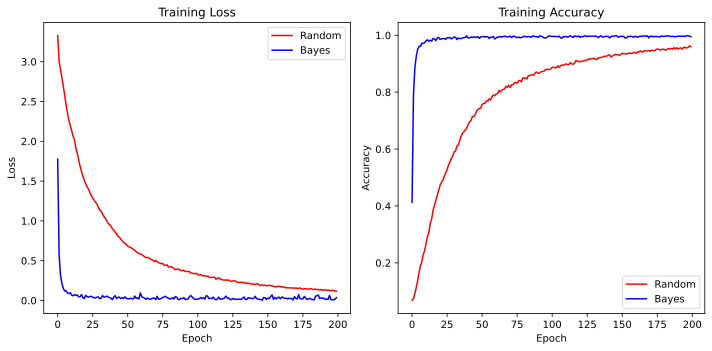

In [9]:
# 绘制训练的准确率和损失曲线
plt.figure(figsize=(10, 5))  # 设置整体图的大小

# 创建第一个子图（上半部分），绘制训练损失曲线
plt.subplot(1, 2, 1)  # 参数依次为：行数，列数，子图编号
plt.plot(range(len(losses_1)), losses_1, color='red', label='Random')
plt.plot(range(len(losses_2)), losses_2, color='blue', label='Bayes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 创建第二个子图（下半部分），绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies_1)), accuracies_1, color='red', label='Random')
plt.plot(range(len(accuracies_2)), accuracies_2, color='blue', label='Bayes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()  # 调整子图的布局，防止重叠

In [8]:
# 测试网络——随机网格搜索——model_1
correct_1 = 0
total_1 = 0
all_preds_1 = []
all_labels_1 = []
model_1.eval()
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model_1(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct_1 += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds_1.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels_1.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total_1 += y.size(0)
accuracy_1 = correct_1/total_1

# 随机网格搜索评价指标
accuracy_score_1 = accuracy_1
kappa_score_1 = cohen_kappa_score(all_labels_1, all_preds_1)
cm_1 = confusion_matrix(all_labels_1, all_preds_1)

print(f'随机网格搜索的测试集精准度: {100*correct_1/total_1} %')

随机网格搜索的测试集精准度: 98.39391326904297 %


In [8]:
# 测试网络——贝叶斯优化——model_2
correct_2 = 0
total_2 = 0
all_preds_2 = []
all_labels_2 = []
model_2.eval()
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model_2(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct_2 += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds_2.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels_2.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total_2 += y.size(0)
accuracy_2 = correct_2/total_2

# 贝叶斯优化评价指标
accuracy_score_2 = accuracy_2
kappa_score_2 = cohen_kappa_score(all_labels_2, all_preds_2)
cm_2 = confusion_matrix(all_labels_2, all_preds_2)
cm_2_ = confusion_matrix(all_labels_2, all_preds_2, normalize='pred') # 计算列归一化的混淆矩阵
cm_2_normalized = (np.round(cm_2_ * 100)).astype(int) # 将归一化矩阵的元素乘以100并保留0位小数

print(f'贝叶斯优化的测试集精准度: {100*correct_2/total_2} %')

贝叶斯优化的测试集精准度: 99.80276489257812 %


In [9]:
report = classification_report(all_labels_2, all_preds_2,output_dict=True)
# 获取加权平均的精确率、召回率、F1系数
weighted_precision = report['macro avg']['precision']
weighted_recall = report['macro avg']['recall']
weighted_f1 = report['macro avg']['f1-score']

print(f"macro Precision: {weighted_precision}")
print(f"macro Recall: {weighted_recall}")
print(f"macro F1 Score: {weighted_f1}")

macro Precision: 0.9978843899971697
macro Recall: 0.9979726973962305
macro F1 Score: 0.9979120249997262


In [13]:
class_accuracy = {label: metrics['precision'] for label, metrics in report.items() if label != 'accuracy'}
df = pd.DataFrame(list(class_accuracy.items()), columns=['Class', 'Accuracy'])
df

,Class,Accuracy
0,0,1.000000
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,4,1.000000
5,5,1.000000
6,6,0.991803
7,7,0.983333
8,8,1.000000
9,9,0.991379


In [15]:
cm_2_ = confusion_matrix(all_labels_2, all_preds_2, normalize='pred') # 计算列归一化的混淆矩阵
cm_2_normalized = (np.round(cm_2_ * 100)).astype(int) # 将归一化矩阵的元素乘以100并保留0位小数

In [16]:
# 保存混淆矩阵
output_folder = 'D:/1_科研进展/小论文/小论文图片/混淆矩阵'

csv_filename_2 = 'final_ANN.csv'
np.savetxt(f'{output_folder}/{csv_filename_2}', cm_2, delimiter=',', fmt='%d')

csv_filename_3 = 'final_ANN_Normalized.csv'
np.savetxt(f'{output_folder}/{csv_filename_3}', cm_2_normalized, delimiter=',', fmt='%d')